# Family Friendly Neighbourhoods in London, UK

## Table of Contents
* [Introduction](#introduction)
* [Data](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

In this project we will try to identify family friendly neighborhood in **London, UK**. This project is targeted towards families looking for new homes or stakeholders who offer housing to families or city planners who are looking to make neighborhoods more family-friendly.

Finding a neighbourhood that is family-friendly can be hard. Especially, in big cities like London. There are many variables to consider such as crime rates and easy access to kid-friendly places such as Parks, Pools, and Libraries, and availability of good schools. 

To determine which neighbourhoods are family-friendly we will focus on neighborhoods with **low crime rates** and easy access to **kid-friendly activities**. 

## Data <a name="data"></a>

To identify family-friendly neighbourhoods we will need the following data:
* Crime Rates for each neighbourhood
* Types of kid-friendly venues
* The Amount of kid-friendly venues in each neighbourhood

We will extract **Crime Rate** data for each neighbourhood from **Metropolitain Police Crime Dashboard**
* This data includes the number of crime incidents for a specific latitude & Longitude 
    - Example:  **Latitude:** 51.471612, **Longitude:** -0.488698, **Crime Incidents:** 2135

We will define our neighborhoods by their **Post Code Pre-fix** which we will obtain with **GeoPy's Reverse Geocoding** with the coordinates obtained from the Crime Rate data. 
* Example: when putting in the **Coordinates:** 51.471612, -0.488698 will return **Postal Code:** TW6 

Kid-friendly Venues data will be obtained by using **Foursquare API**. The total number of venues within that Category will be calculated for each postal code.
* Example: **Postal Code:** BR1	**Coordinates:** 51.411807, 0.021526 **Parks:** 12 **Library:** 3 **Pool:** 3 **Playground:** 4	**Cinemas:** 0

#### Import & Install Libraries

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use(['ggplot'])
import requests
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans


In [4]:
! pip install folium

     |████████████████████████████████| 92kB 13.7MB/s eta 0:00:01


In [5]:
import folium

### Data Acquisition & Cleaning
Import Crime Dataset downloaded from  <a href = "https://www.met.police.uk/sd/stats-and-data/"> Metropolitan Police </a>

In [6]:
# The code was removed by Watson Studio for sharing.

In [136]:
crime = pd.read_csv(streaming_body_1)

In [137]:
print(crime.shape)
crime.head(30)

(657, 6)


,OCU Name,SNT Code,SNT Name,Latitude (generated),Longitude (generated),Sum Value
0,Aviation Security(SO18),SATST5,Heathrow Terminal 5,51.471612,-0.488698,2135
1,Aviation Security(SO18),SATST4,Heathrow Terminal 4,51.459600,-0.447453,18
2,Aviation Security(SO18),SATST3,Heathrow Terminal 3,51.470644,-0.459297,1017
3,Aviation Security(SO18),SATST2,Heathrow Terminal 2,51.470264,-0.448120,1021
4,Aviation Security(SO18),SALHR,Heathrow Airport,51.469852,-0.455192,1208
5,Westminster,RPST,St James Park,51.502728,-0.133745,338
6,Richmond upon Thames,RPRI,Richmond Park,51.441700,-0.275066,172
7,Westminster,RPRE,Regents Park and Primrose Hill,51.531772,-0.155752,300
8,Westminster,RPHY,Hyde Park and Kensington Gardens,51.506936,-0.171263,1375
9,Greenwich,RPGR,Greenwich Park,51.477220,0.000932,62


Drop Unnecessary Columns 

In [138]:
crime.drop('SNT Code',axis = 1, inplace = True)
crime.drop('OCU Name', axis= 1, inplace= True)
crime.head()

,SNT Name,Latitude (generated),Longitude (generated),Sum Value
0,Heathrow Terminal 5,51.471612,-0.488698,2135
1,Heathrow Terminal 4,51.459600,-0.447453,18
2,Heathrow Terminal 3,51.470644,-0.459297,1017
3,Heathrow Terminal 2,51.470264,-0.448120,1021
4,Heathrow Airport,51.469852,-0.455192,1208


Rename Latitude, Longitude & Sum Value Columns

In [139]:
crime.rename(columns = {'Latitude (generated)': 'Latitude','Longitude (generated)': 'Longitude','Sum Value':'Crime_Incid'} ,inplace = True)

In [140]:
crime.head()

,SNT Name,Latitude,Longitude,Crime_Incid
0,Heathrow Terminal 5,51.471612,-0.488698,2135
1,Heathrow Terminal 4,51.459600,-0.447453,18
2,Heathrow Terminal 3,51.470644,-0.459297,1017
3,Heathrow Terminal 2,51.470264,-0.448120,1021
4,Heathrow Airport,51.469852,-0.455192,1208


Prepare Dataframe for reverse geo-coding and create and empty Postal Code column

In [141]:
 crime['Postal_Code'] = ''
crime.head()

,SNT Name,Latitude,Longitude,Crime_Incid,Postal_Code
0,Heathrow Terminal 5,51.471612,-0.488698,2135,
1,Heathrow Terminal 4,51.459600,-0.447453,18,
2,Heathrow Terminal 3,51.470644,-0.459297,1017,
3,Heathrow Terminal 2,51.470264,-0.448120,1021,
4,Heathrow Airport,51.469852,-0.455192,1208,


####  Reverse Geocoding

In [142]:
for i in range(len(crime)):
    geolocator = Nominatim(user_agent='UK_Explorer')
    Lat = crime.loc[i,'Latitude']
    Lon = crime.loc[i,'Longitude']
    #save to a tuple for use in geocoder
    p = (Lat, Lon)
    location = geolocator.reverse(p, timeout = 200)
    #if location is None:
        #continue
    raw = location.raw
    #print(raw)
    try:
        post = raw['address']['postcode'].split(' ')
        crime.loc[i,'Postal_Code'] = post[0]
    except KeyError:
        continue


Determine the unique postal codes and make sure that it only contains the prefix

In [143]:
crime['Postal_Code'].unique()


array(['', 'TW6', 'SW1H', 'TW10', 'NW1', 'W2', 'SE10', 'TW11', 'SW16',
       'CR0', 'CR2', 'SE22', 'SE1', 'SW1V', 'W10', 'W9', 'NW8', 'WC2H',
       'SW1P', 'W1F', 'W1S', 'W1J', 'W1U', 'SW3', 'WC2E', 'SW15', 'SW19',
       'SW18', 'SW11', 'SW8', 'SW12', 'SW17', 'E17', 'E11', 'E4', 'IG8',
       'E10', 'E1', 'E2', 'E1W', 'E14', 'E3', 'KT4', 'CR4', 'SM6', 'SM5',
       'SM1', 'SM2', 'SM3', 'SE21', 'SE15', 'SE16', 'SE5', 'SE17', 'TW2',
       'TW1', 'TW9', 'SW13', 'TW12', 'KT1', 'SW14', 'E12', 'IG3', 'IG6',
       'IG5', 'IG4', 'E18', 'RM6', 'IG2', 'IG1', 'E15', 'E6', 'E16',
       'E13', 'E7', 'E20', 'KT3', 'SM4', 'SW20', 'SE6', 'SE14', 'SE26',
       'SE23', 'SE12', 'SE4', 'SE8', 'BR1', 'SE13', 'SE3', 'SW9', 'SW2',
       'SE11', 'SW4', 'SE27', 'SE24', 'KT2', 'KT6', 'KT9', 'KT5', 'W8',
       'W11', 'W14', 'SW5', 'SW7', 'SW10', 'N7', 'N1', 'N19', 'N5', 'N4',
       'EC1', 'EC1V', 'W4', 'TW8', 'TW7', 'TW5', 'TW13', 'TW14', 'TW4',
       'TW3', 'UB7', 'UB4', 'HA4', 'UB3', 'HA6', 'UB10', 

There are a few postal codes that contain more then just the prefix so we will manually fix each one.
The following post codes need to be fixed
* EC1V
* W1F, W1S, W1J, W1U
* WC2H, WC2E
* WC1H, WC1R , WC1E
* SW1H, SW1V, SW1P

In [144]:
crime[crime['Postal_Code'].str.contains('EC1')]

,SNT Name,Latitude,Longitude,Crime_Incid,Postal_Code
310,Clerkenwell,51.526372,-0.108157,4141,EC1
311,Bunhill,51.524736,-0.094382,6117,EC1V


In [145]:
crime.loc[311,'Postal_Code'] = 'EC1'
crime[crime['Postal_Code'].str.contains('EC1')]

,SNT Name,Latitude,Longitude,Crime_Incid,Postal_Code
310,Clerkenwell,51.526372,-0.108157,4141,EC1
311,Bunhill,51.524736,-0.094382,6117,EC1


In [146]:
crime[crime['Postal_Code'].str.startswith('W1')]

,SNT Name,Latitude,Longitude,Crime_Incid,Postal_Code
18,Queen's Park,51.529404,-0.208688,2136,W10
29,Soho,51.513396,-0.134791,13790,W1F
31,Oxford Street Regent Street and Bond Street,51.513524,-0.145582,23954,W1S
32,Mayfair and St James,51.509184,-0.146482,9855,W1J
33,Marylebone High Street,51.518724,-0.152344,5703,W1U
282,Pembridge,51.511072,-0.198439,2094,W11
283,Norland,51.509256,-0.209890,1214,W11
284,Holland,51.501492,-0.207034,1656,W14
285,Golborne,51.522744,-0.208603,2601,W10
288,Colville,51.515604,-0.204163,3834,W11


In [147]:
crime.loc[29,'Postal_Code'] = 'W1'
crime.loc[31,'Postal_Code'] = 'W1'
crime.loc[32,'Postal_Code'] = 'W1'
crime.loc[33,'Postal_Code'] = 'W1'
crime[crime['Postal_Code'].str.startswith('W1')]

,SNT Name,Latitude,Longitude,Crime_Incid,Postal_Code
18,Queen's Park,51.529404,-0.208688,2136,W10
29,Soho,51.513396,-0.134791,13790,W1
31,Oxford Street Regent Street and Bond Street,51.513524,-0.145582,23954,W1
32,Mayfair and St James,51.509184,-0.146482,9855,W1
33,Marylebone High Street,51.518724,-0.152344,5703,W1
282,Pembridge,51.511072,-0.198439,2094,W11
283,Norland,51.509256,-0.209890,1214,W11
284,Holland,51.501492,-0.207034,1656,W14
285,Golborne,51.522744,-0.208603,2601,W10
288,Colville,51.515604,-0.204163,3834,W11


In [148]:
crime[crime['Postal_Code'].str.contains('WC2')]

,SNT Name,Latitude,Longitude,Crime_Incid,Postal_Code
24,West End and China Town,51.509496,-0.131107,10447,WC2H
37,Covent Garden,51.512192,-0.123645,7172,WC2E


In [149]:
crime.loc[24,'Postal_Code'] = 'WC2'
crime.loc[37,'Postal_Code'] = 'WC2'
crime[crime['Postal_Code'].str.contains('WC2')]

,SNT Name,Latitude,Longitude,Crime_Incid,Postal_Code
24,West End and China Town,51.509496,-0.131107,10447,WC2
37,Covent Garden,51.512192,-0.123645,7172,WC2


In [150]:
crime[crime['Postal_Code'].str.contains('WC1')]

,SNT Name,Latitude,Longitude,Crime_Incid,Postal_Code
543,King's Cross,51.527092,-0.121348,4637,WC1H
546,Holborn and Covent Garden,51.518972,-0.117714,11394,WC1R
554,Bloomsbury,51.521940,-0.131467,11715,WC1E


In [151]:
crime.loc[543,'Postal_Code'] = 'WC1'
crime.loc[546,'Postal_Code'] = 'WC1'
crime.loc[554,'Postal_Code'] = 'WC1'
crime[crime['Postal_Code'].str.contains('WC1')]

,SNT Name,Latitude,Longitude,Crime_Incid,Postal_Code
543,King's Cross,51.527092,-0.121348,4637,WC1
546,Holborn and Covent Garden,51.518972,-0.117714,11394,WC1
554,Bloomsbury,51.521940,-0.131467,11715,WC1


In [152]:
crime[crime['Postal_Code'].str.contains('SW1')]

,SNT Name,Latitude,Longitude,Crime_Incid,Postal_Code
5,St James Park,51.502728,-0.133745,338,SW1H
11,Norbury and Pollards Hill,51.405932,-0.122650,1668,SW16
17,Tachbrook,51.487824,-0.134301,1169,SW1V
25,Warwick,51.490820,-0.142878,1788,SW1V
26,Vincent Square,51.494748,-0.131485,4329,SW1P
38,Churchill,51.487536,-0.146892,1383,SW1V
41,West Putney,51.458224,-0.233752,1922,SW15
42,West Hill,51.444600,-0.214364,1507,SW19
43,Wandsworth Common,51.447052,-0.175887,2438,SW18
44,Thamesfield,51.465236,-0.216905,3129,SW15


In [153]:
crime.loc[5,'Postal_Code'] = 'SW1'
crime.loc[17,'Postal_Code'] = 'SW1'
crime.loc[25,'Postal_Code'] = 'SW1'
crime.loc[26,'Postal_Code'] = 'SW1'
crime.loc[38,'Postal_Code'] = 'SW1'
crime[crime['Postal_Code'].str.contains('SW1')]

,SNT Name,Latitude,Longitude,Crime_Incid,Postal_Code
5,St James Park,51.502728,-0.133745,338,SW1
11,Norbury and Pollards Hill,51.405932,-0.122650,1668,SW16
17,Tachbrook,51.487824,-0.134301,1169,SW1
25,Warwick,51.490820,-0.142878,1788,SW1
26,Vincent Square,51.494748,-0.131485,4329,SW1
38,Churchill,51.487536,-0.146892,1383,SW1
41,West Putney,51.458224,-0.233752,1922,SW15
42,West Hill,51.444600,-0.214364,1507,SW19
43,Wandsworth Common,51.447052,-0.175887,2438,SW18
44,Thamesfield,51.465236,-0.216905,3129,SW15


Check one more time that all unique postal codes only contain the prefix

In [154]:
crime['Postal_Code'].unique()

array(['', 'TW6', 'SW1', 'TW10', 'NW1', 'W2', 'SE10', 'TW11', 'SW16',
       'CR0', 'CR2', 'SE22', 'SE1', 'W10', 'W9', 'NW8', 'WC2', 'W1',
       'SW3', 'SW15', 'SW19', 'SW18', 'SW11', 'SW8', 'SW12', 'SW17',
       'E17', 'E11', 'E4', 'IG8', 'E10', 'E1', 'E2', 'E1W', 'E14', 'E3',
       'KT4', 'CR4', 'SM6', 'SM5', 'SM1', 'SM2', 'SM3', 'SE21', 'SE15',
       'SE16', 'SE5', 'SE17', 'TW2', 'TW1', 'TW9', 'SW13', 'TW12', 'KT1',
       'SW14', 'E12', 'IG3', 'IG6', 'IG5', 'IG4', 'E18', 'RM6', 'IG2',
       'IG1', 'E15', 'E6', 'E16', 'E13', 'E7', 'E20', 'KT3', 'SM4',
       'SW20', 'SE6', 'SE14', 'SE26', 'SE23', 'SE12', 'SE4', 'SE8', 'BR1',
       'SE13', 'SE3', 'SW9', 'SW2', 'SE11', 'SW4', 'SE27', 'SE24', 'KT2',
       'KT6', 'KT9', 'KT5', 'W8', 'W11', 'W14', 'SW5', 'SW7', 'SW10',
       'N7', 'N1', 'N19', 'N5', 'N4', 'EC1', 'W4', 'TW8', 'TW7', 'TW5',
       'TW13', 'TW14', 'TW4', 'TW3', 'UB7', 'UB4', 'HA4', 'UB3', 'HA6',
       'UB10', 'UB9', 'UB8', 'RM14', 'RM2', 'RM13', 'RM12', 'RM1', 'RM7

Manually research and enter Postal Code for missing values

In [155]:
crime[crime['Postal_Code'] == '']

,SNT Name,Latitude,Longitude,Crime_Incid,Postal_Code
0,Heathrow Terminal 5,51.471612,-0.488698,2135,
19,Maida Vale,51.529744,-0.189492,1503,
27,Victoria Business and Transport,51.495932,-0.143349,3647,
28,Strand and Whitehall,51.505036,-0.129495,10416,
64,Valley,51.612788,-0.024374,2869,
65,Markhouse,51.576920,-0.030410,2489,
67,Leyton,51.561808,-0.015974,3018,
80,Cathall,51.556412,0.000249,2088,
201,East Village and International Quarter,51.546344,-0.009290,826,
331,Hounslow South,51.462988,-0.350034,1072,


In [157]:
crime.loc[0,'Postal_Code'] = 'TW6'
crime.loc[19,'Postal_Code'] = 'W9'
crime.loc[27,'Postal_Code'] = 'SW1'
crime.loc[28,'Postal_Code'] = 'SW1'
crime.loc[64,'Postal_Code'] = 'E4'
crime.loc[65,'Postal_Code'] = 'E17'
crime.loc[67,'Postal_Code'] = 'E10'
crime.loc[80,'Postal_Code'] = 'E11'
crime.loc[201,'Postal_Code'] = 'E15'
crime.loc[331,'Postal_Code'] = 'TW3'
crime.loc[402,'Postal_Code'] = 'N17'
crime.loc[434,'Postal_Code'] = 'E9'
crime.loc[437,'Postal_Code'] = 'E2'
crime.loc[440,'Postal_Code'] = 'N1'
crime.loc[442,'Postal_Code'] = 'N16'
crime.loc[443,'Postal_Code'] = 'N16'
crime.loc[473,'Postal_Code'] = 'N18'
crime.loc[577,'Postal_Code'] = 'BR1'
crime[crime['Postal_Code'] == '']

,SNT Name,Latitude,Longitude,Crime_Incid,Postal_Code


In [158]:
# The code was removed by Watson Studio for sharing.

{'file_name': 'crime_dataset.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcapstone-donotdelete-pr-rsep68kqo6tjq4',
 'asset_id': '682a6520-dc26-4aa6-ae50-9b52b1050dd5'}

In [6]:
# The code was removed by Watson Studio for sharing.

,SNT Name,Latitude,Longitude,Sum Value,Postal_Code
0,Heathrow Terminal 5,51.471612,-0.488698,2135,TW6
1,Heathrow Terminal 4,51.459600,-0.447453,18,TW6
2,Heathrow Terminal 3,51.470644,-0.459297,1017,TW6
3,Heathrow Terminal 2,51.470264,-0.448120,1021,TW6
4,Heathrow Airport,51.469852,-0.455192,1208,TW6


Group by Postal Code

In [160]:
crime_grp = crime.groupby(['Postal_Code'],as_index = False).agg({'Latitude':'mean','Longitude':'mean','Crime_Incid': 'sum'})

In [161]:
print(crime_grp.shape)
crime_grp.head(30)

(212, 4)


,Postal_Code,Latitude,Longitude,Crime_Incid
0,BR1,51.411807,0.021526,12549
1,BR2,51.379531,0.016897,4068
2,BR3,51.403436,-0.032268,6933
3,BR4,51.377884,-0.011548,1190
4,BR5,51.392603,0.104314,7497
5,BR6,51.353672,0.086733,5655
6,BR7,51.413072,0.074307,2135
7,CR0,51.371688,-0.076356,31987
8,CR2,51.346243,-0.064082,5074
9,CR4,51.402778,-0.158683,9678


## Analysis <a name="analysis"></a>

Map Data

In [15]:
#obtain latitude and longitude for London
geolocator = Nominatim(user_agent='UK_Explorer')
location1 = geolocator.geocode('London, UK')
lon_lat = location1.latitude
lon_lng = location1.longitude

In [202]:
#Create a map for London with all the Postal Codes Plotted
london_map = folium.Map(location = [lon_lat, lon_lng], zoom_start = 9.5)
for lat, lng, post, crime in zip(crime_grp['Latitude'], crime_grp['Longitude'], crime_grp['Postal_Code'], crime_grp['Crime_Incid']):
    label = '{}: Crime: {}'.format(post, crime)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker([lat, lng], 
                        radius = 4, 
                        popup = label, 
                        color = 'blue', 
                        fill = True, 
                        fill_opacity = 0.6, 
                       parse_html = False).add_to(london_map)
london_map

#### Determine Distribution of Crime 

In [168]:
crime_grp.describe()

,Latitude,Longitude,Crime_Incid
count,212.000000,212.000000,212.000000
mean,51.506033,-0.121700,7950.141509
std,0.076781,0.165796,6424.225975
min,51.310216,-0.476216,927.000000
25%,51.453754,-0.229237,3929.250000
50%,51.510783,-0.121981,6273.000000
75%,51.562922,-0.011192,10072.750000
max,51.667308,0.268724,53302.000000


**Quick Analysis:** 50% of Crime in London is between 3929 incidents and 10,072 incidents with the average being 7,950. 

We can visualize this in a box plot. 

Text(0, 0.5, '# of Crime Incidents')

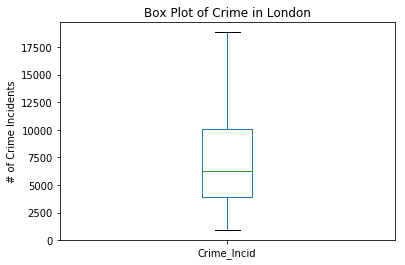

In [203]:
crime_grp['Crime_Incid'].plot(kind = 'box', showfliers=False)
plt.title('Box Plot of Crime in London')
plt.ylabel('# of Crime Incidents')


Let's Map this data. We will assume that anything within the interquartile range is average amount of crime. Anything below is low crime (safe) and anything above  is high crime (unsafe).

In [204]:
london_crime_map = folium.Map(location = [lon_lat, lon_lng], zoom_start = 10)
for lat, lng, post, crime in zip(crime_grp['Latitude'], crime_grp['Longitude'], crime_grp['Postal_Code'], crime_grp['Crime_Incid']):
    label = '{}: Crime: {} incidents'.format(post, crime)
    label = folium.Popup(label, parse_html = True)
    if int(crime) < 3929:
        color="green" 
    elif int(crime) >  10072:
        color = "red"
    else: 
        color="yellow"
    folium.CircleMarker([lat, lng], 
                        radius = 4, 
                        popup = label, 
                        color = color,
                        fill = True, 
                        fill_opacity = 0.6, 
                        parse_html = False).add_to(london_crime_map)
london_crime_map

### Venue Search

Lets now find the number of family friendly venues in each Postal Code. 

Family Friendly Venues are considered to be: 

**Parks** (Category Id: '4bf58dd8d48988d163941735')

**Libraries** (Category Id: '4bf58dd8d48988d12f941735')

**Lidos (Pools)** (Category Id: '4bf58dd8d48988d15e941735')

**Playgrounds** (Category Id: '4bf58dd8d48988d1e7941735')

**Cinemas** (Category Id: '4bf58dd8d48988d180941735')

In [172]:
# The code was removed by Watson Studio for sharing.

Define a function that will count the number of venues in each category 

In [174]:
def Get_Number_Of_Venues(ID, category):
    for i in range(len(crime_grp)):
        p_lat =crime_grp.iloc[i,1]
        p_lon =crime_grp.iloc[i,2]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,p_lat,p_lon,VERSION,ID,Radius,LIMIT) 
        test_results = requests.get(url).json()
        test_venue = test_results['response']['venues']
        count = np.shape(test_venue)
        crime_grp.loc[i, category] = count[0]

Create empty columns for each Venue Type

In [175]:
crime_grp['Park'] = ''
crime_grp['Library'] = ''
crime_grp['Pool'] = ''
crime_grp['Playground'] = ''
crime_grp['Cinemas'] = ''
crime_grp.head()

,Postal_Code,Latitude,Longitude,Crime_Incid,Park,Library,Pool,Playground,Cinemas
0,BR1,51.411807,0.021526,12549,,,,,
1,BR2,51.379531,0.016897,4068,,,,,
2,BR3,51.403436,-0.032268,6933,,,,,
3,BR4,51.377884,-0.011548,1190,,,,,
4,BR5,51.392603,0.104314,7497,,,,,


In [176]:
Get_Number_Of_Venues('4bf58dd8d48988d163941735','Park')
Get_Number_Of_Venues( '4bf58dd8d48988d12f941735','Library')
Get_Number_Of_Venues('4bf58dd8d48988d15e941735','Pool')
Get_Number_Of_Venues('4bf58dd8d48988d1e7941735','Playground')
Get_Number_Of_Venues('4bf58dd8d48988d180941735','Cinemas')
crime_grp.head(30)

KeyError: 'venues'

In [15]:
# The code was removed by Watson Studio for sharing.

{'file_name': 'venue_dataset.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcapstone-donotdelete-pr-rsep68kqo6tjq4',
 'asset_id': '69c7f58b-9f49-4bdf-91d6-69f5182cc904'}

In [7]:
# The code was removed by Watson Studio for sharing.

,Postal_Code,Latitude,Longitude,Sum Value,Park,Library,Pool,Playground,Cinemas
0,BR1,51.411807,0.021526,12549,12,3,3,4,0.0
1,BR2,51.379531,0.016897,4068,10,0,0,1,0.0
2,BR3,51.403436,-0.032268,6933,13,2,1,3,0.0
3,BR4,51.377884,-0.011548,1190,10,1,1,2,0.0
4,BR5,51.392603,0.104314,7497,6,1,1,2,0.0


In [8]:
crime_grp.rename(columns = {'Sum Value':'Crime_Incid'}, inplace = True)
crime_grp.head()

,Postal_Code,Latitude,Longitude,Crime_Incid,Park,Library,Pool,Playground,Cinemas
0,BR1,51.411807,0.021526,12549,12,3,3,4,0.0
1,BR2,51.379531,0.016897,4068,10,0,0,1,0.0
2,BR3,51.403436,-0.032268,6933,13,2,1,3,0.0
3,BR4,51.377884,-0.011548,1190,10,1,1,2,0.0
4,BR5,51.392603,0.104314,7497,6,1,1,2,0.0


In [9]:
# Cinemas Column is a float when read from csv lets change it to an integer
crime_grp['Cinemas']= crime_grp['Cinemas'].astype('int')
crime_grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 9 columns):
Postal_Code    212 non-null object
Latitude       212 non-null float64
Longitude      212 non-null float64
Crime_Incid    212 non-null int64
Park           212 non-null int64
Library        212 non-null int64
Pool           212 non-null int64
Playground     212 non-null int64
Cinemas        212 non-null int64
dtypes: float64(2), int64(6), object(1)
memory usage: 15.0+ KB


### Clustering

Select a subset of the data that only includes Crime incidents and Venues

In [10]:
ldn_cluster = crime_grp.iloc[:,3:]
print(crime_grp.shape)
print(ldn_cluster.shape)
ldn_cluster.head()

(212, 9)
(212, 6)


,Crime_Incid,Park,Library,Pool,Playground,Cinemas
0,12549,12,3,3,4,0
1,4068,10,0,0,1,0
2,6933,13,2,1,3,0
3,1190,10,1,1,2,0
4,7497,6,1,1,2,0


In [11]:
cluster_num = 3
ldn_kmeans = KMeans(n_clusters = cluster_num, random_state = 0).fit(ldn_cluster)

In [12]:
crime_grp.insert(0,'Cluster_Labels', ldn_kmeans.labels_)
crime_grp.head()

,Cluster_Labels,Postal_Code,Latitude,Longitude,Crime_Incid,Park,Library,Pool,Playground,Cinemas
0,2,BR1,51.411807,0.021526,12549,12,3,3,4,0
1,0,BR2,51.379531,0.016897,4068,10,0,0,1,0
2,0,BR3,51.403436,-0.032268,6933,13,2,1,3,0
3,0,BR4,51.377884,-0.011548,1190,10,1,1,2,0
4,0,BR5,51.392603,0.104314,7497,6,1,1,2,0


In [13]:
crime_grp.tail()

,Cluster_Labels,Postal_Code,Latitude,Longitude,Crime_Incid,Park,Library,Pool,Playground,Cinemas
207,0,W7,51.512152,-0.337295,4082,14,3,0,2,0
208,0,W8,51.500025,-0.192390,6294,26,14,3,7,0
209,0,W9,51.526587,-0.189827,5980,29,12,2,24,0
210,1,WC1,51.522668,-0.123510,27746,50,49,14,20,13
211,2,WC2,51.510844,-0.127376,17619,50,38,10,23,11


#### Visualize clusters

In [16]:
cluster_map = folium.Map(location = [lon_lat, lon_lng], zoom_start = 10)
for lat, lng, post, crime, cluster in zip(crime_grp['Latitude'], crime_grp['Longitude'], crime_grp['Postal_Code'], crime_grp['Crime_Incid'], crime_grp['Cluster_Labels']):
    label = 'Cluster #: {} Postal Code: {} Crime: {} incidents'.format(cluster,post, crime)
    label = folium.Popup(label, parse_html = True)
    if cluster == 0:
        color="green" 
    elif cluster == 1:
        color = "red"
    else: 
        color="yellow"
    folium.CircleMarker([lat, lng], 
                        radius = 4, 
                        popup = label, 
                        color = color,
                        fill = True, 
                        fill_opacity = 0.6, 
                        parse_html = False).add_to(cluster_map)
cluster_map

#### Check optimal # of clusters
We Originally selected three clusters because this is the number of categories we used when analyzing the crime data. 

But lets check if this is the optimal number of clusters

In [60]:
elbow = []
for k in range(1,len(ldn_cluster)):
    km = KMeans(n_clusters = k, random_state = 0).fit(ldn_cluster)
    elbow.append(km.inertia_)  

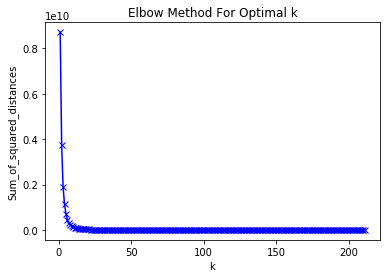

In [106]:
K = range(1,len(ldn_cluster))
#plt.figure(figsize =(20,10))
plt.plot(K,  elbow,'bx-')
plt.xlabel('k')  
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Impossible to see the elbow point. Although can see it occurs much closer to 0, so we will replot with just a subset of the data

In [110]:
elbow2 = elbow[0:10]

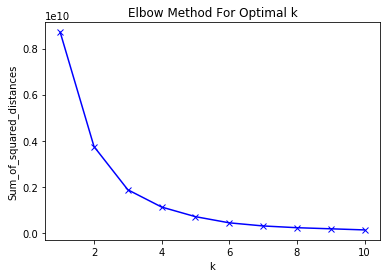

In [111]:
K = range(1,11)
#plt.figure(figsize =(20,10))
plt.plot(K,  elbow2,'bx-')
plt.xlabel('k')  
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Optimal k = 3 according to plot 

## Results &  Discussion <a name="results"></a>

In [17]:
Neighborhoods_Good = crime_grp[crime_grp['Cluster_Labels'] == 0]
Neighborhoods_Bad = crime_grp[crime_grp['Cluster_Labels'] == 1]
Neighborhoods_Caut = crime_grp[crime_grp['Cluster_Labels'] == 2]
print( '# of Family Friendly Neighborhoods: ' + str(len(Neighborhoods_Good)))
print( '# of Neighborhoods to Avoid: ' + str(len(Neighborhoods_Bad)))
print( '# of Neighborhoods to be Cautious of: ' + str(len(Neighborhoods_Caut)))

# of Family Friendly Neighborhoods: 136
# of Neighborhoods to Avoid: 9
# of Neighborhoods to be Cautious of: 67


([<matplotlib.axis.XTick at 0x7f69748f0e10>,
 <a list of 3 Text xticklabel objects>)

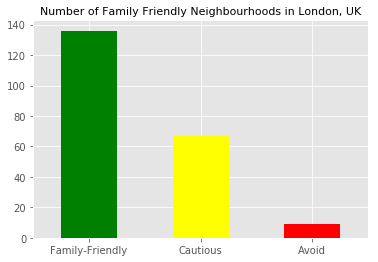

In [41]:
#Box plot of above data
crime_grp['Cluster_Labels'].value_counts().plot(kind = 'bar', color =['green', 'yellow', 'red'])
plt.title('Number of Family Friendly Neighbourhoods in London, UK', fontsize = 11)
plt.xticks(np.arange(3), ('Family-Friendly', 'Cautious', 'Avoid'), rotation = 'horizontal')

Based on the results there appears to be plenty of Family Friendly neighborhoods to choose from in London. 

There also appears to be only a few neighborhoods that need to be avoided. With most of these being centrally located. 

##### Postal Codes to Avoid

In [197]:
Neighborhoods_Bad['Postal_Code']

7       CR0
28      E17
71       N1
93      NW1
94     NW10
117     SE1
151     SW1
196      W1
210     WC1
Name: Postal_Code, dtype: object

#### Top 20 Safest Postal Codes

In [226]:
sorted_df = Neighborhoods_Good.sort_values(by = 'Crime_Incid', axis = 0, ascending = True)                                            
sorted_df.reset_index(drop = True, inplace = True)
sorted_df.head(20)

,Cluster_Labels,Postal_Code,Latitude,Longitude,Crime_Incid,Park,Library,Pool,Playground,Cinemas
0,0,UB9,51.598416,-0.476216,927,0,1,0,1,0
1,0,TN16,51.316248,0.023685,1022,0,0,1,0,0
2,0,RM11,51.575036,0.231794,1034,5,1,0,1,0
3,0,SM3,51.378752,-0.210024,1058,18,3,2,7,1
4,0,SW14,51.461460,-0.267102,1188,14,2,1,4,0
5,0,BR4,51.377884,-0.011548,1190,10,1,1,2,0
6,0,RM4,51.612940,0.174366,1560,6,0,0,1,0
7,0,IG4,51.585016,0.051319,1681,6,1,1,2,0
8,0,KT5,51.388204,-0.282316,1771,12,1,0,4,0
9,0,E18,51.590212,0.025738,1803,9,3,0,2,1


#### Top 20 Family-Friendly Postal Codes with the most Kid-friendly Venus

In [228]:
Neighborhoods_Good['Total_Venues'] = Neighborhoods_Good['Park'] + Neighborhoods_Good['Library'] + Neighborhoods_Good['Pool'] + Neighborhoods_Good['Playground'] + Neighborhoods_Good['Cinemas']
Neighborhoods_Good.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Cluster_Labels,Postal_Code,Latitude,Longitude,Crime_Incid,Park,Library,Pool,Playground,Cinemas,Total_Venues
1,0,BR2,51.379531,0.016897,4068,10,0,0,1,0,11
2,0,BR3,51.403436,-0.032268,6933,13,2,1,3,0,19
3,0,BR4,51.377884,-0.011548,1190,10,1,1,2,0,14
4,0,BR5,51.392603,0.104314,7497,6,1,1,2,0,10
5,0,BR6,51.353672,0.086733,5655,3,0,1,1,0,5


In [230]:
sorted_df2 = Neighborhoods_Good.sort_values(by = 'Total_Venues', axis = 0, ascending = False)                                            
sorted_df2.reset_index(drop = True, inplace = True)
sorted_df2.head(20)

,Cluster_Labels,Postal_Code,Latitude,Longitude,Crime_Incid,Park,Library,Pool,Playground,Cinemas,Total_Venues
0,0,SE11,51.490164,-0.114848,3281,50,17,4,30,1,102
1,0,E1W,51.506548,-0.061429,2604,50,12,3,12,2,79
2,0,N5,51.554956,-0.101980,6018,40,11,4,20,1,76
3,0,NW8,51.529281,-0.171654,5631,32,10,2,26,2,72
4,0,W10,51.523821,-0.214136,7985,34,11,6,16,1,68
5,0,W9,51.526587,-0.189827,5980,29,12,2,24,0,67
6,0,NW5,51.549024,-0.146840,5981,29,11,3,22,1,66
7,0,N19,51.566828,-0.131623,5963,31,8,2,22,1,64
8,0,SW5,51.491196,-0.195267,2783,29,13,3,10,2,57
9,0,SE5,51.471373,-0.088170,8095,29,8,4,13,1,55


##### Further Analysis & Improvement Ideas

**1. Add more kid-friendly venues for analysis.** 
   - Parks, Playgrounds, Libraries, Pools, and Cinnemas are not the only kid friendly activities that could be available.

**2. Add Boundaries for each Postal Code**
   - Currently only using a 1 mile radius to define the boundaries of the Postal Codes assigned latitudes and longitudes. This could cause some unwanted overlapping of postal code zones while searching venues. This would also allow for chlorpleth maps to be made. 
   
**3. Standardize Crime Incidents based on population within the Postal Code.**
   - It is noted that many of the postal codes that are to be avoided are centrally located where the population density is most likely larger then the postal codes further from the central. This could causes the crime rate to look superficially high. 
   
**4. Filter the results further by budget** 
   - This will help better cater to families of all budgets.London is an expensive city to live in, especially when it comes to housing. The average cost for renting  2 bedroom apartment in London is $2338 (£1875) making it the 6th most expensive rental market in the world according to Business Insider. London ranks 8th most expensive place to buy in the world based on average propety price.  

## Conclusion <a name="conclusion"></a>

After evaluating the crime rates of different postal codes we then obtained kid friendly actiities within a mile of the post codes. Further clustering the results in order to get the most family-friendly neigborhoods based on all of our criteria.

The results suggest there are many family-friendly neighborhoods to choose from. Which is great news as many people believe it is impossible to find family-friendly neighborhoods in Big Cities. There are 136 family-friendly Postal Codes located all across London. So stakeholders would not have a problem finding the right neighborhood based on their own preferences,needs & budget.

It should be noted that some of the neighborhoods ranked as the safest do not have many identified kid-friendly activities. But some stakeholders may find this as helpful information because it would be a prime location to open/build kid friendly venues to attract new families to the neighborhood and solve a problem for the families already living there. 